# Complete architecture

## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm


plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU support is enabled.")
else:
    print("GPU support is NOT enabled.")

GPU support is enabled.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /

In [5]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    root_directory_work = '/content/drive/MyDrive/Progetto_gait_recognition'

print('root directory is ' + root_directory)

root directory is /content


## Train/Test Split


In [6]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv('/content/drive/MyDrive/Progetto_gait_recognition/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)

def process_string(r):
    compl_type = r[:-6]
    return compl_type

reference_df['Complete_type'] = reference_df.apply(lambda row: process_string(row['Name_file']), axis=1)

def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Complete_type,Complete_path
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9_antalgic_T14,/content/dataset/subject9/antalgic/trial14/Sbj...
...,...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8_normal_T17,/content/dataset/subject8/normal/trial17/Sbj8_...
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8_normal_T6,/content/dataset/subject8/normal/trial6/Sbj8_n...


In [7]:
joint_sk_p_df = reference_df.groupby('Complete_type').agg({
    'Complete_path': list,
    'Label': 'first'
    }).reset_index()

joint_sk_p_df['Label'] = joint_sk_p_df['Label'].astype(int)
joint_sk_p_df['Subject'] = joint_sk_p_df['Complete_type'].str[:5].str.replace('_', '')

joint_sk_p_df

,Complete_type,Complete_path,Label,Subject
0,Sbj10_antalgic_T1,[/content/dataset/subject10/antalgic/trial1/Sb...,0,Sbj10
1,Sbj10_antalgic_T10,[/content/dataset/subject10/antalgic/trial10/S...,0,Sbj10
2,Sbj10_antalgic_T11,[/content/dataset/subject10/antalgic/trial11/S...,0,Sbj10
3,Sbj10_antalgic_T12,[/content/dataset/subject10/antalgic/trial12/S...,0,Sbj10
4,Sbj10_antalgic_T13,[/content/dataset/subject10/antalgic/trial13/S...,0,Sbj10
...,...,...,...,...
1435,Sbj9_trendelenburg_T5,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1436,Sbj9_trendelenburg_T6,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1437,Sbj9_trendelenburg_T7,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1438,Sbj9_trendelenburg_T8,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9


In [8]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

# train_val_test split
train = joint_sk_p_df[~joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]
test = joint_sk_p_df[joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]


#frequence counts
print("Train")
print(train['Label'].value_counts(), '\n')
print("Test")
print(test['Label'].value_counts(), '\n')

train

Train
Label
0    220
1    220
2    220
3    220
4    220
5    220
Name: count, dtype: int64 

Test
Label
0    20
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64 



,Complete_type,Complete_path,Label,Subject
0,Sbj10_antalgic_T1,[/content/dataset/subject10/antalgic/trial1/Sb...,0,Sbj10
1,Sbj10_antalgic_T10,[/content/dataset/subject10/antalgic/trial10/S...,0,Sbj10
2,Sbj10_antalgic_T11,[/content/dataset/subject10/antalgic/trial11/S...,0,Sbj10
3,Sbj10_antalgic_T12,[/content/dataset/subject10/antalgic/trial12/S...,0,Sbj10
4,Sbj10_antalgic_T13,[/content/dataset/subject10/antalgic/trial13/S...,0,Sbj10
...,...,...,...,...
1435,Sbj9_trendelenburg_T5,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1436,Sbj9_trendelenburg_T6,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1437,Sbj9_trendelenburg_T7,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1438,Sbj9_trendelenburg_T8,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9


## Load and preprocessing

### Skeleton

In [9]:
def load_data_sk(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    data = df_skelly.to_numpy().reshape((-1,32,3))

    return data.squeeze()



def remove_joints(data, joint_list, load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly



def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


In [10]:
def load_prep_sk(complete_path, joints = ['rarm', 'larm', 'head'], load = True):
    data = load_data_sk(complete_path, load)
    data = normalize_data_sk(data)
    data = remove_joints(data, joints, load = False)

    return data.astype(np.float32)

### Pressure

In [11]:
def load_data_ps(complete_path, load=True):

    if load:
      complete_path = complete_path.decode()

    pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

    return pressure_data.squeeze()


def normalize_data_ps(data):
    massimo = np.max(data)
    data = data / massimo
    return data


def baricenter(data):
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

    # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
    # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

    # Compute the distances between each point and the barycenter
    shift_x = -(x_barycenter - data.shape[1]/2)
    shift_y = -(y_barycenter - data.shape[0]/2)

    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(shift_x), axis=1)
    shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

    # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
    # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
    # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

    return shifted_matrix

In [12]:
def load_prep_ps(complete_path):
    data = load_data_ps(complete_path, load=True)
    data = normalize_data_ps(data)
    data = baricenter(data)

    return data.astype(np.float32)

### Complete

In [13]:
def load_prep(lista):

    ele1 = lista[0].decode()

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    skeletron = load_prep_sk(sk).reshape(-1)
    pressure = load_prep_ps(p).reshape(-1)

    joint_vector = np.concatenate((skeletron, pressure))

    return joint_vector

In [14]:
def random_crop(data, target_size=50, center_crop=False):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)

    noise_time_begin = int(sk.shape[0]/2) - 10
    noise_time_end = 5

    # remove initial and final frames that we consider as noise
    start = noise_time_begin
    end = sk.shape[0] - noise_time_end

    sk = sk[start:end, :]

    N = sk.shape[0]

    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
        # print('Start of the crop: ', from_)
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
        # print('Start of the crop: ', from_)

    sk_cropped = sk[from_:from_ + target_size]
    sk_cropped = sk_cropped.reshape(-1)

    final_vector = np.concatenate((sk_cropped, p))

    return final_vector

In [15]:
def random_flip(data, flip_prob=0.5):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)
    p = p.reshape(128, 48)

    x_data = sk[:, :, 0]
    y_data = sk[:, :, 1]
    z_data = sk[:, :, 2]

    prob = np.random.rand()

    if prob < flip_prob:
        x_data = 1 - x_data
        p = np.flip(p, axis=1)

    sk_flipped = np.dstack((x_data, y_data, z_data))

    sk_flipped = sk_flipped.reshape(-1)
    p_flipped = p.reshape(-1)

    final_vector = np.concatenate((sk_flipped, p_flipped))

    return final_vector



## Dataset

In [16]:
def create_dataset(table, cache_file, shuffle, batch_size, num_sbj, target_size=50, center_crop=False, train=False, validation=False, test=False, flip_rate=0.5, repeat=True):

    subject_0 = 'Sbj' + str(num_sbj)
    # subject_1 = 'Sbj' + str(num_sbj+1)

    if num_sbj == 0:
        new_table = table

    else:
        if train:
          new_table = table[table['Subject'] != subject_0]
          # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

        elif validation:
          new_table = table[table['Subject'] == subject_0]
          # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

        elif test:
          new_table = table

        else:
          print("Error, select train, validation or test setting")
          return None


    # shape
    input_size = (target_size*12*3+128*48)

    # Convert dataframe to lists
    file_names = list(new_table['Complete_path'])
    labels = new_table['Label']

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Map the load_and_preprocess_data function
    py_func = lambda path, label: (tf.numpy_function(load_prep, [path], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    if repeat:
        dataset = dataset.repeat()

    # Map the crop function
    py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, center_crop], tf.float32), input_size), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the flip function
    py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_flip, [data, flip_rate], tf.float32), input_size), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)


    return dataset

In [17]:
# batch = 30

# sbj = 1
# train_name_file = 'train_0' + str(sbj)

# dataset_train_0 = create_dataset(table = train,
#                                cache_file = train_name_file,
#                                shuffle = True,
#                                batch_size = batch,
#                                num_sbj=sbj,
#                                train = True)


# train_steps_sk = int(np.ceil(1200/batch))

# first_element_dataset = dataset_train_0.take(1)
# first_element_dataset

# for d, l in first_element_dataset:

#     dati = d[0]
#     print(dati.shape)
#     sk = dati[:-6144].numpy().reshape(-1, 12, 3)
#     p = dati[-6144:].numpy().reshape(128, 48)

#     print(l.numpy())
#     print(l[0].numpy())


In [18]:
# batch = 30

# sbj = 1
# val_name_file = 'val_0' + str(sbj)

# dataset_val_0 = create_dataset(table = train,
#                                 cache_file = val_name_file,
#                                 shuffle = False,
#                                 batch_size = batch,
#                                 num_sbj = sbj,
#                                 validation = True,
#                                 repeat = False)


# # extract truth labels
# num_samples_to_extract = 100
# dataset_sample = dataset_val_0.take(num_samples_to_extract)

# extracted_labels = []
# for _, label in dataset_sample:
#     extracted_labels.extend(label.numpy().tolist())

# true_label = np.array(extracted_labels)
# true_label.shape

## Final model

In [19]:
def cls(X, l=0.01):

    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(l))(X)

    return X

In [20]:
def ConvPool2d(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    X = tf.keras.layers.Conv2D(conv_feature_maps, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    return X

In [21]:
def Encoder_sk(X_input, code_size):

    X = ConvPool2d(X_input, conv_feature_maps=16, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=32, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=64, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=128, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # Compress state
    X = tf.keras.layers.Flatten()(X)
    X_out = tf.keras.layers.Dense((code_size))(X)

    return X_out

In [22]:
def Encoder_p(X_input, code_size):

    X = ConvPool2d(X_input, conv_feature_maps=16, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=32, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=64, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=128, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = tf.keras.layers.Flatten()(X)
    X_out = tf.keras.layers.Dense((code_size))(X)

    return X_out

In [23]:
def complete_architecture(input_shape):

    X_input = tf.keras.Input(input_shape)

    # skeletron input
    X_input_sk = X_input[:, :50*12*3]
    X_sk = keras.layers.Reshape((50, 12, 3))(X_input_sk)

    # pressure input
    X_input_p = X_input[:, 50*12*3:]
    X_p = keras.layers.Reshape((128, 48, 1))(X_input_p)

    # creation of compress code
    code_sk = Encoder_sk(X_sk, 200)
    code_p = Encoder_p(X_p, 100)

    joint_code = tf.keras.layers.Concatenate()([code_sk, code_p])

    X = cls(joint_code, l=0.01)
    X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X_out, name='CNN_p_classifier')

    return model

dim_input = 50*12*3 + 128*48

final_model = complete_architecture((dim_input, ))
final_model.summary()

Model: "CNN_p_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7944)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 1800)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 6144)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 12, 3)      │              0 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 128, 48, 1)     │              0 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 12, 16)     │            448 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 126, 46, 16)    │            160 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 12, 16)     │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 126, 46, 16)    │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 50, 12, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 126, 46, 16)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 25, 6, 16)      │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 63, 23, 16)     │              0 │ activation_4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 25, 6, 32)      │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 61, 21, 32)     │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 25, 6, 32)      │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 61, 21, 32)     │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 721,186 (2.75 MB)

 Trainable params: 719,626 (2.75 MB)

 Non-trainable params: 1,560 (6.09 KB)

## K-fold cross validation


-----------------------------------------------------
Subject out:  1
Stopped at epoch:  200
Validation loss achived is:  0.41765
Validation accuracy achived is:  0.895833
-----------------------------------------------------


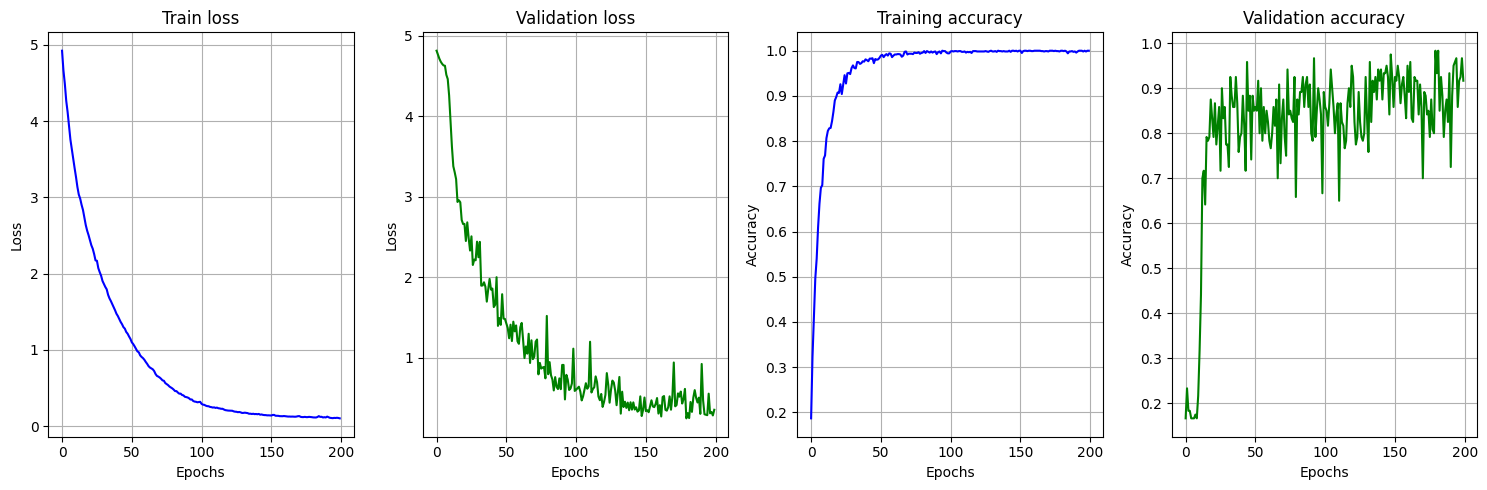

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8656 - loss: 0.4488



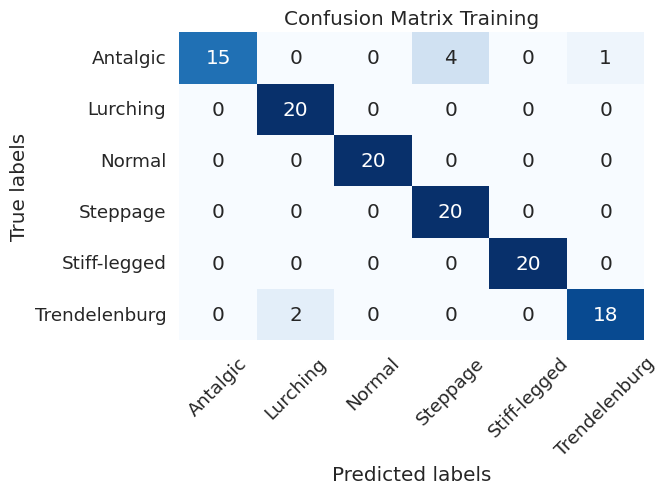


-----------------------------------------------------
Subject out:  2
Stopped at epoch:  127
Validation loss achived is:  0.637151
Validation accuracy achived is:  0.848333
-----------------------------------------------------


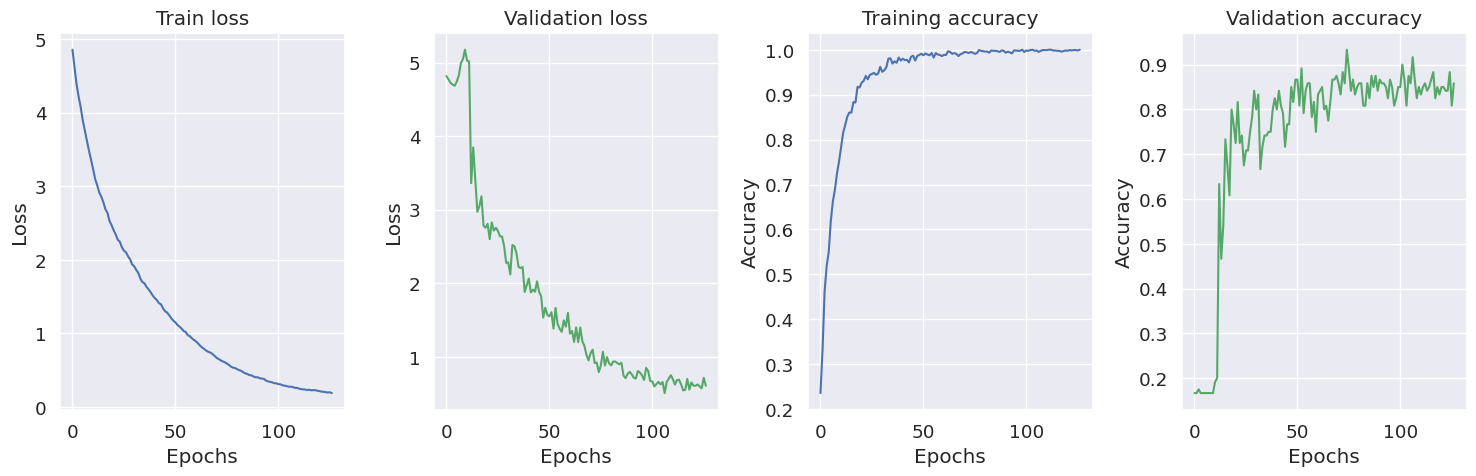

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7911 - loss: 0.7965



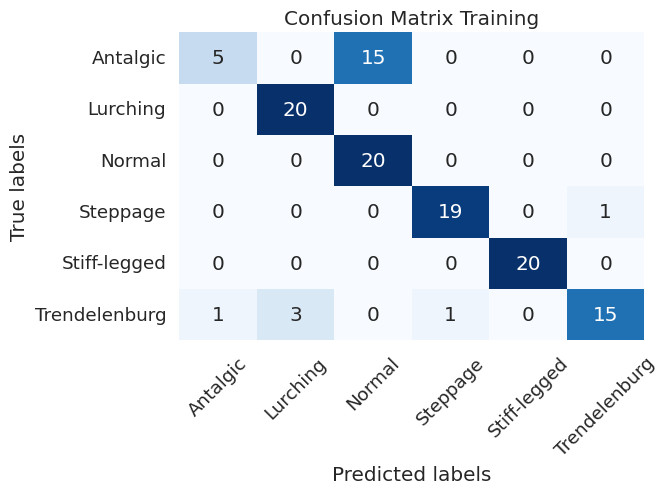


-----------------------------------------------------
Subject out:  3
Stopped at epoch:  168
Validation loss achived is:  0.418834
Validation accuracy achived is:  0.89125
-----------------------------------------------------


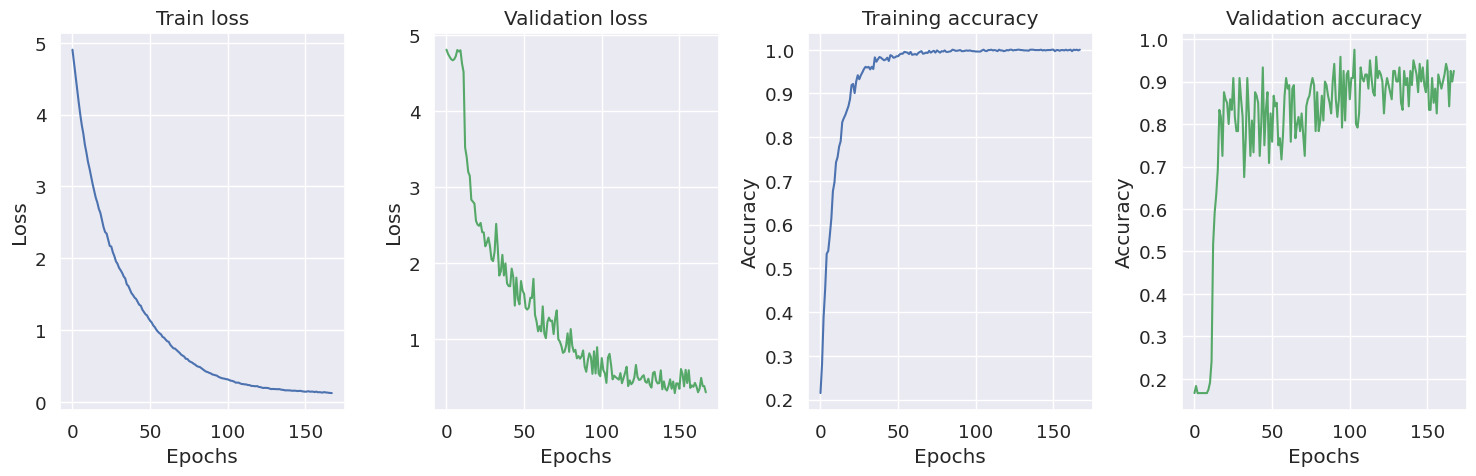

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9489 - loss: 0.3429



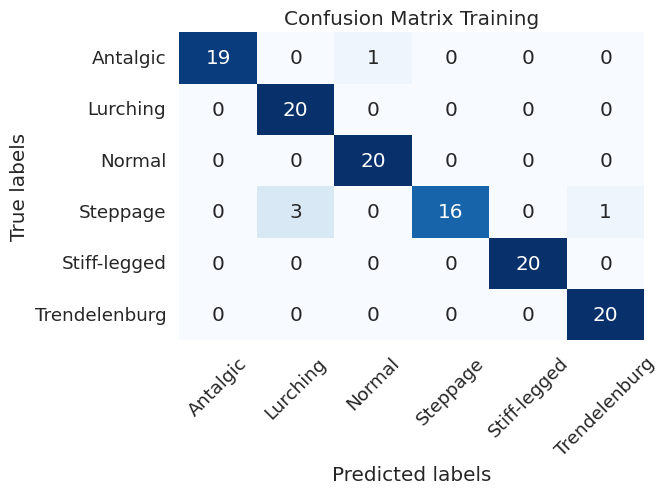


-----------------------------------------------------
Subject out:  4
Stopped at epoch:  132
Validation loss achived is:  0.459764
Validation accuracy achived is:  0.89125
-----------------------------------------------------


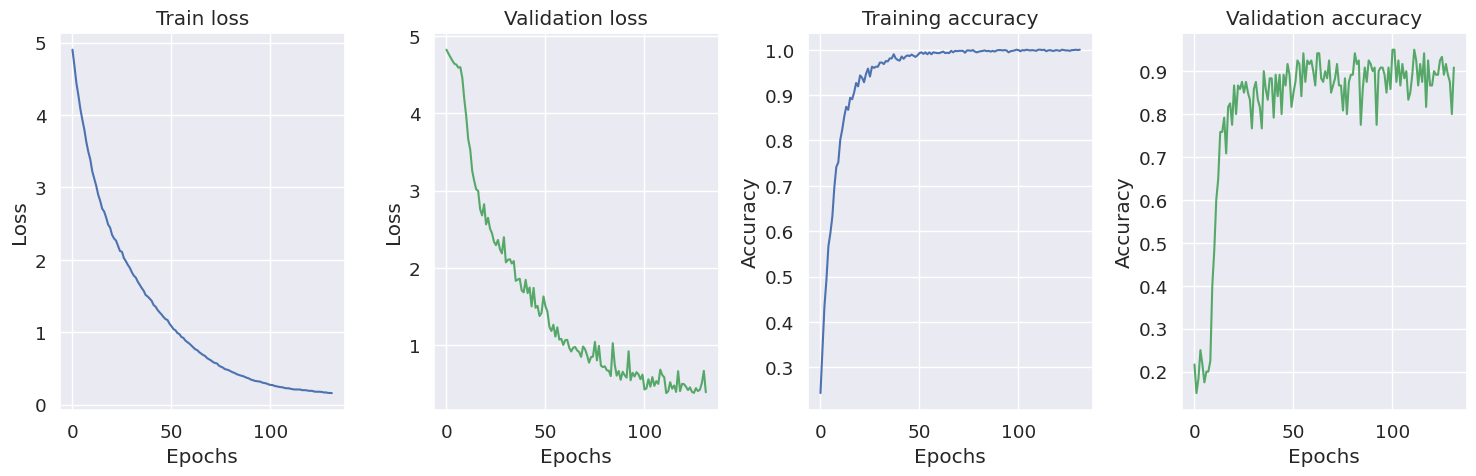

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9211 - loss: 0.3530



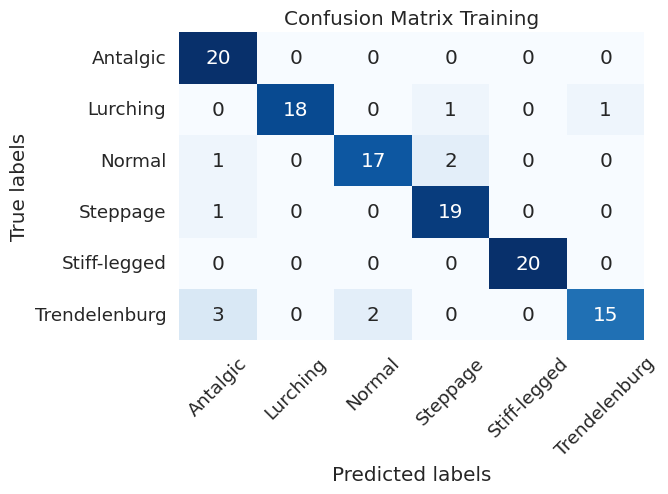


-----------------------------------------------------
Subject out:  5
Stopped at epoch:  163
Validation loss achived is:  0.837462
Validation accuracy achived is:  0.755833
-----------------------------------------------------


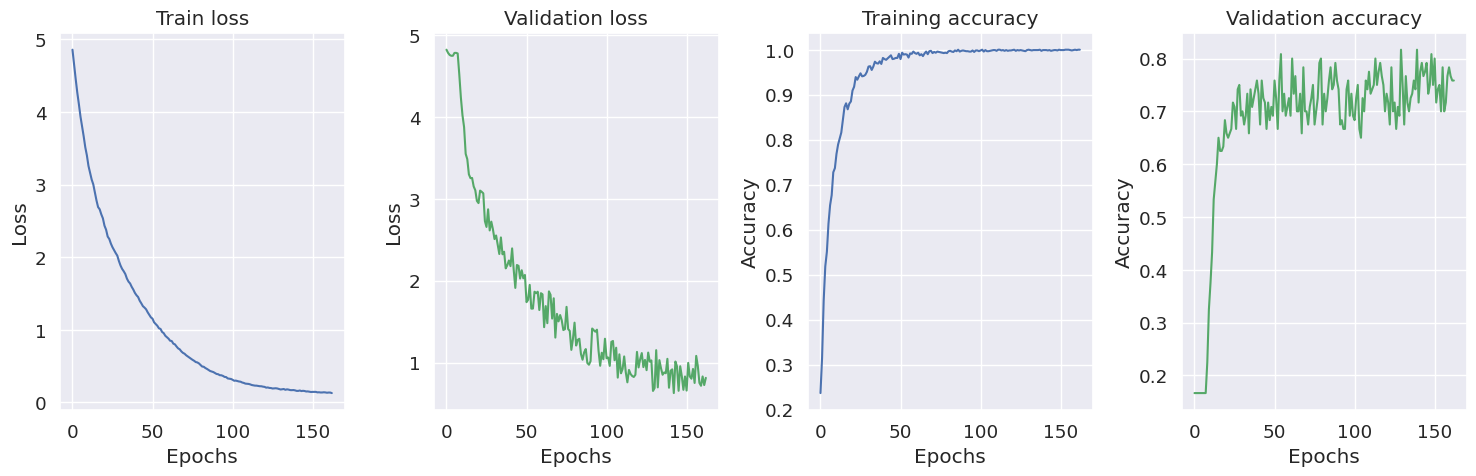

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8444 - loss: 0.5490



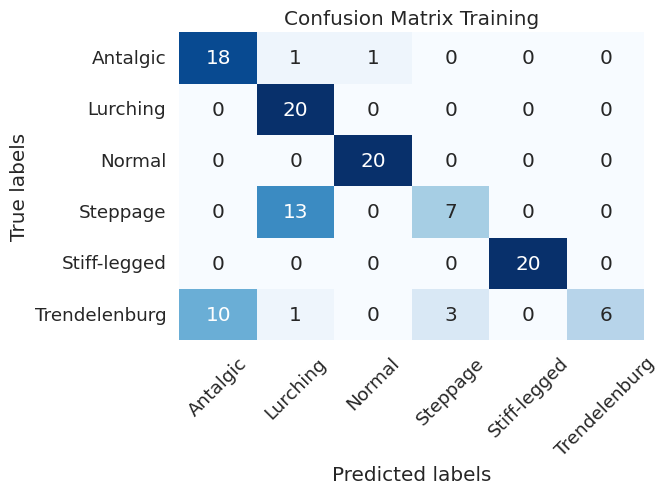


-----------------------------------------------------
Subject out:  6
Stopped at epoch:  127
Validation loss achived is:  0.883479
Validation accuracy achived is:  0.790833
-----------------------------------------------------


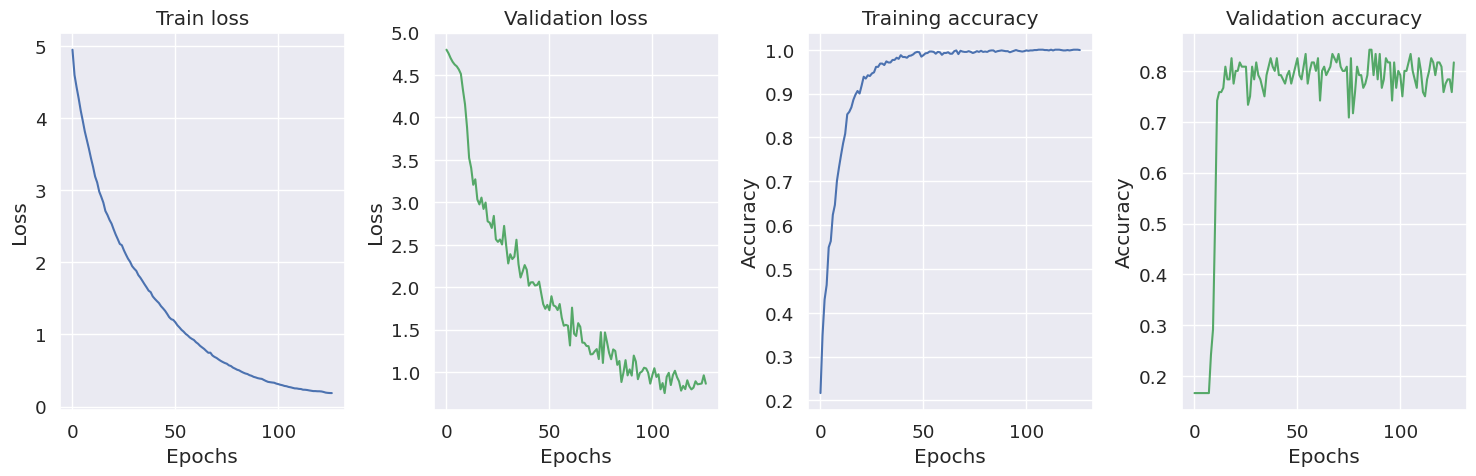

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8567 - loss: 0.7347



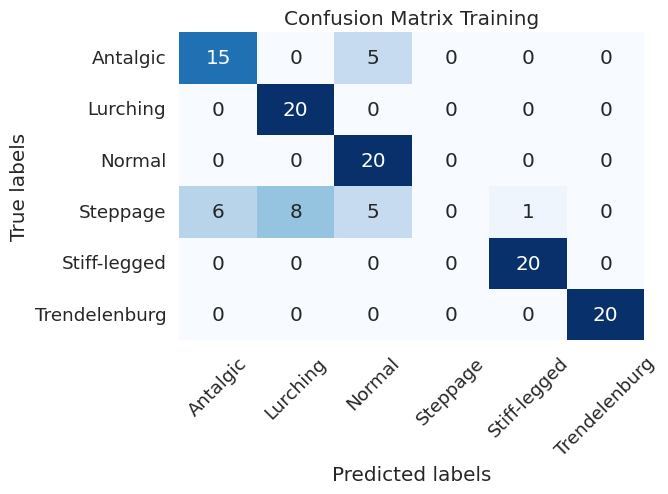


-----------------------------------------------------
Subject out:  7
Stopped at epoch:  113
Validation loss achived is:  1.186091
Validation accuracy achived is:  0.715417
-----------------------------------------------------


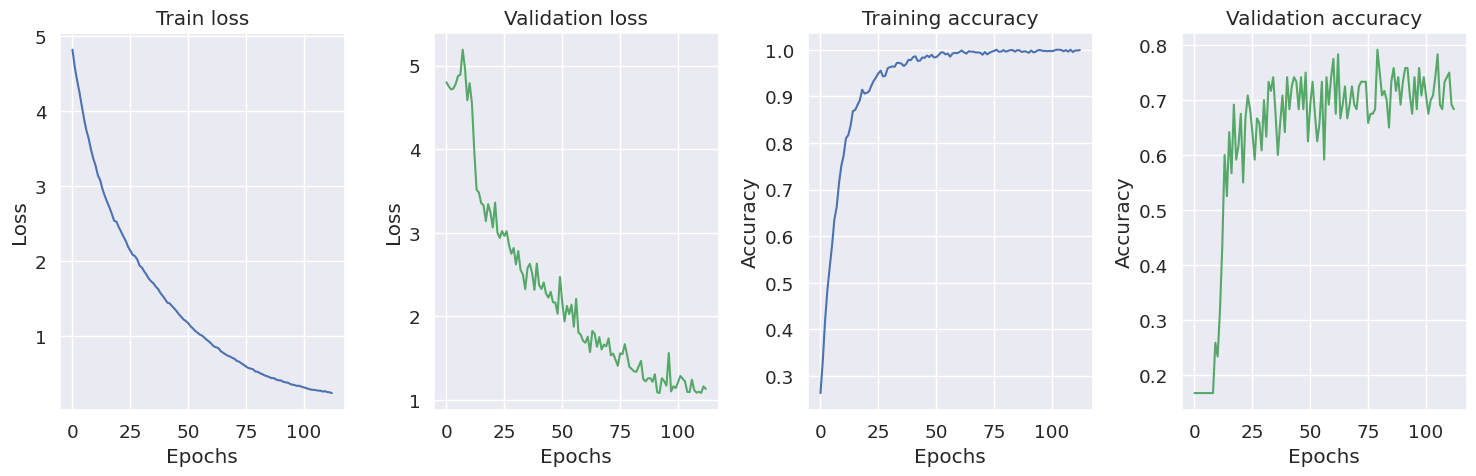

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6556 - loss: 1.1828



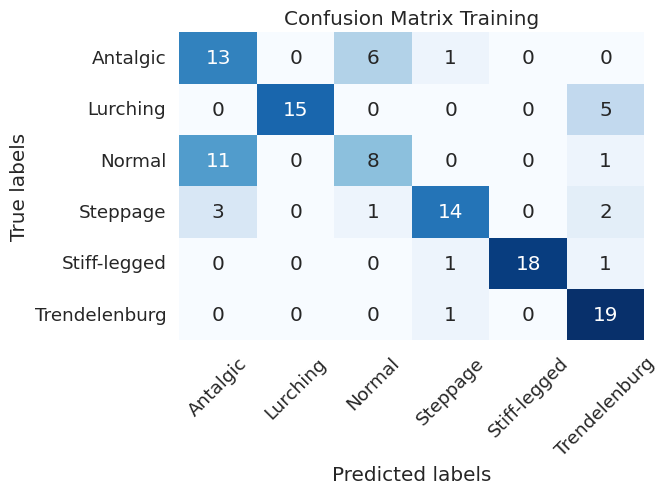


-----------------------------------------------------
Subject out:  8
Stopped at epoch:  187
Validation loss achived is:  0.508763
Validation accuracy achived is:  0.8675
-----------------------------------------------------


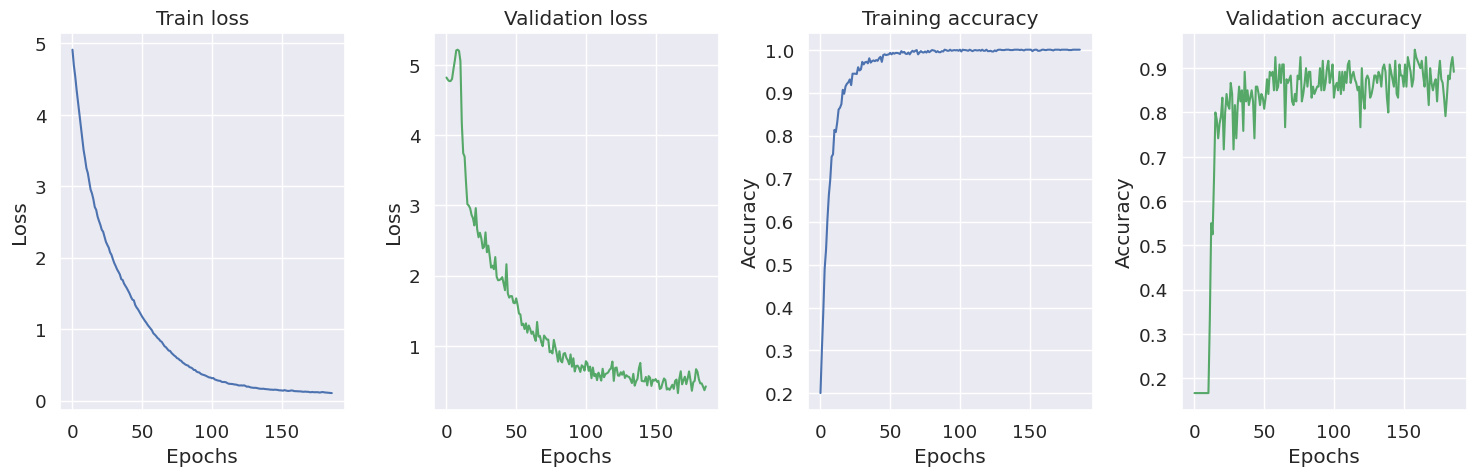

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9444 - loss: 0.3332



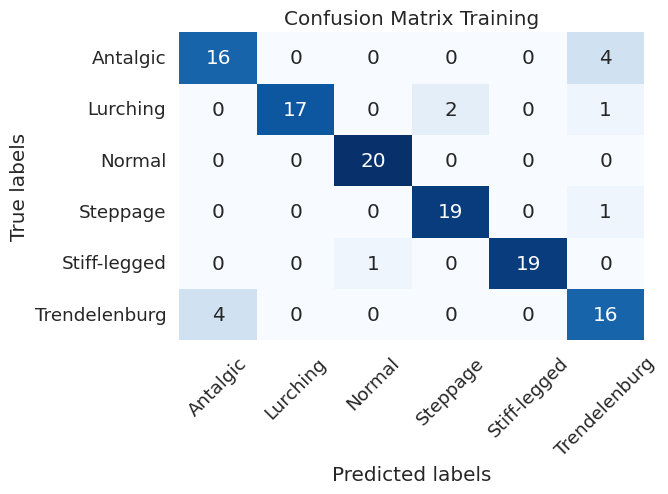


-----------------------------------------------------
Subject out:  9
Stopped at epoch:  121
Validation loss achived is:  1.051619
Validation accuracy achived is:  0.7275
-----------------------------------------------------


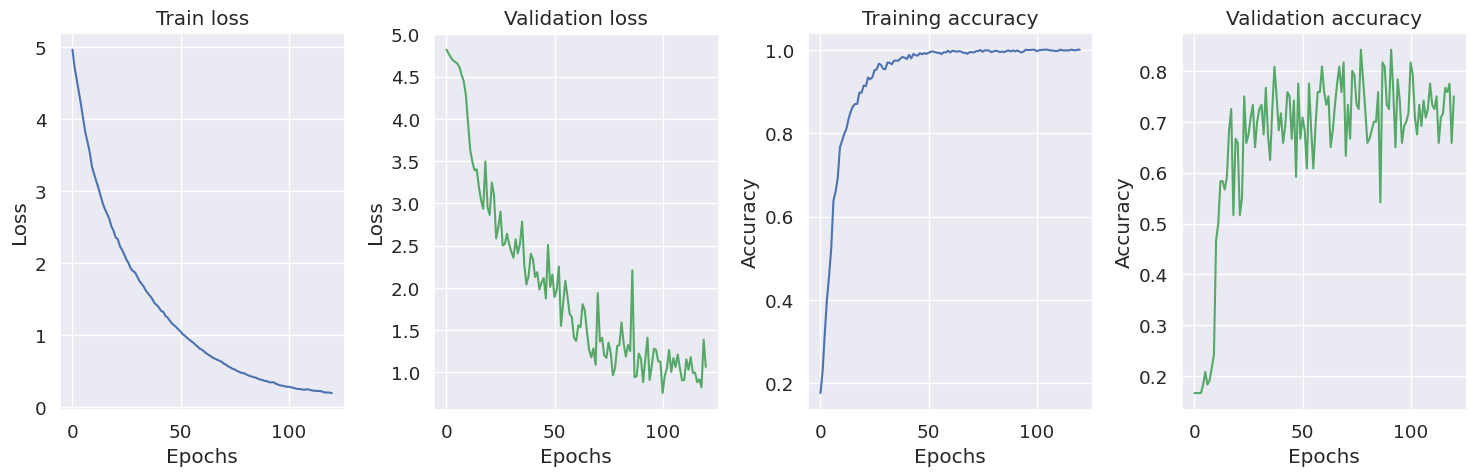

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7122 - loss: 0.9214



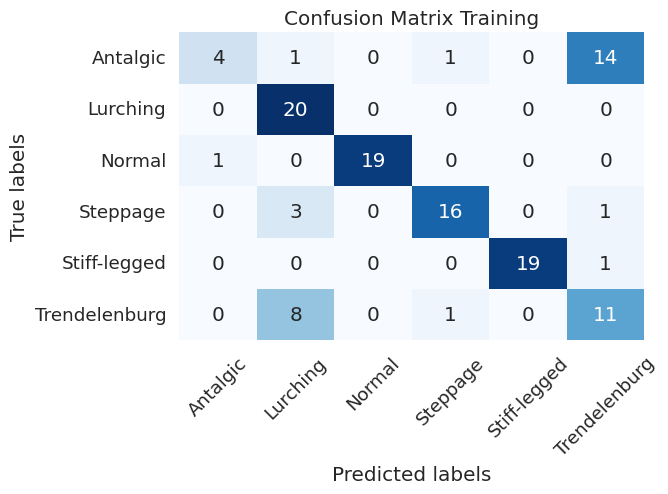


-----------------------------------------------------
Subject out:  10
Stopped at epoch:  142
Validation loss achived is:  1.206343
Validation accuracy achived is:  0.680833
-----------------------------------------------------


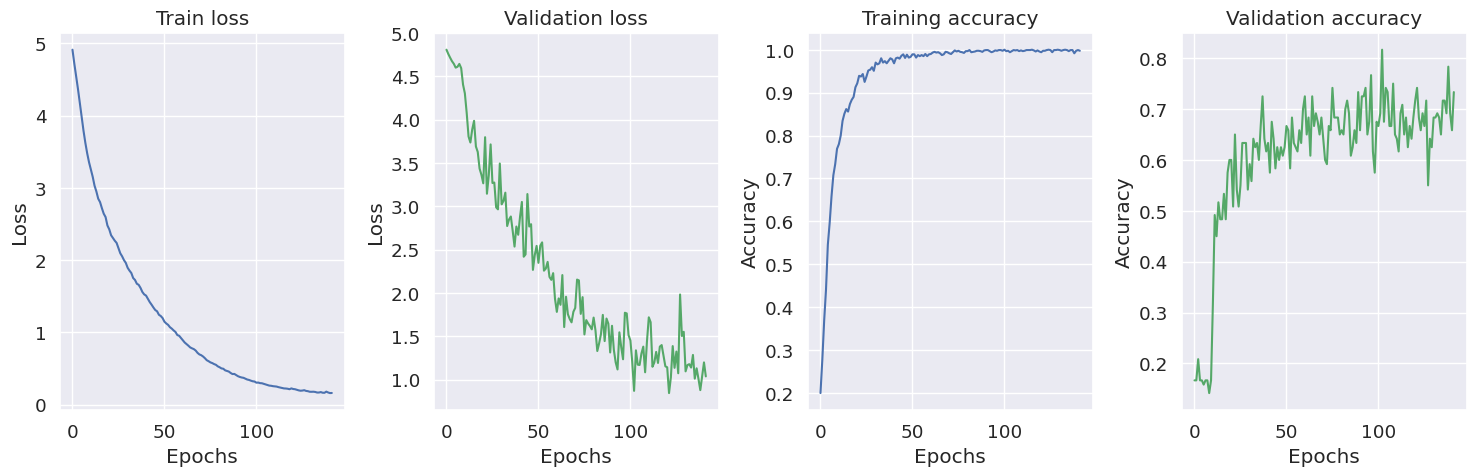

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7811 - loss: 0.8521



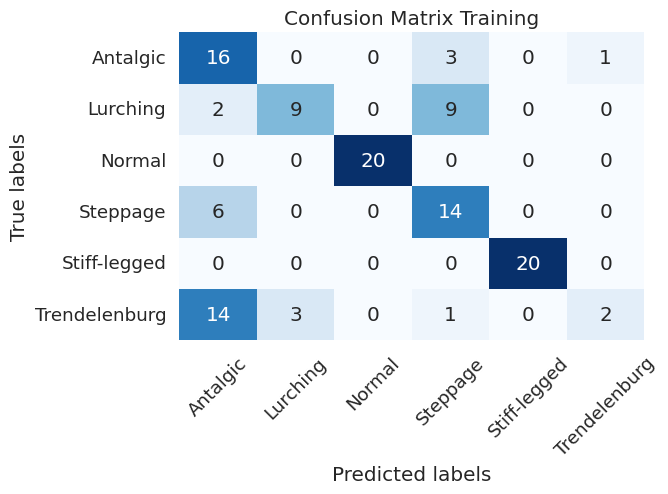


-----------------------------------------------------
Subject out:  11
Stopped at epoch:  114
Validation loss achived is:  0.911028
Validation accuracy achived is:  0.755833
-----------------------------------------------------


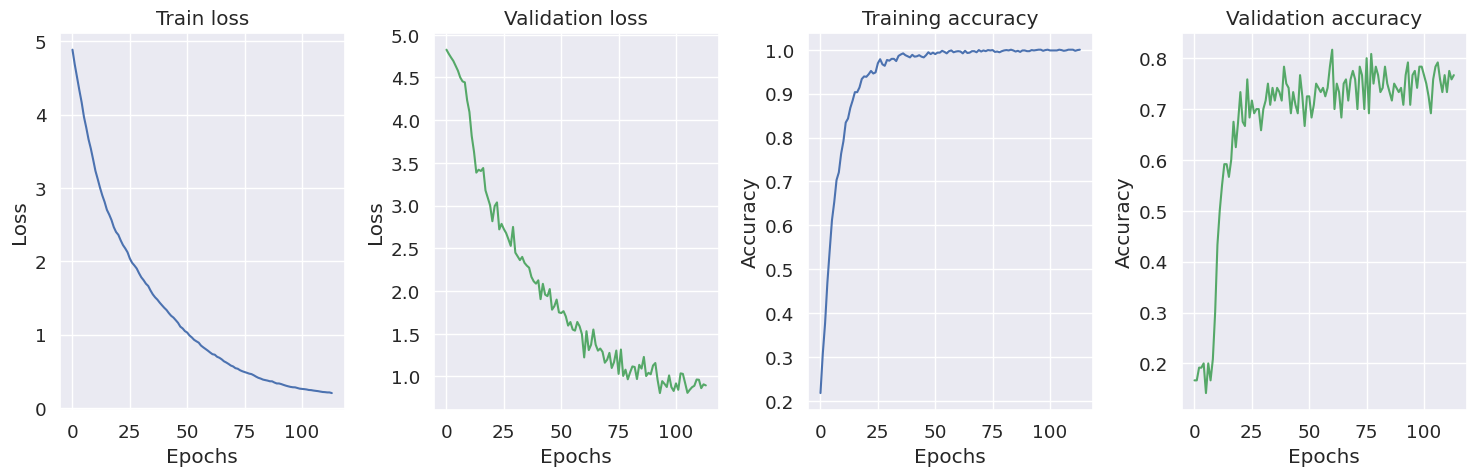

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7889 - loss: 0.8313



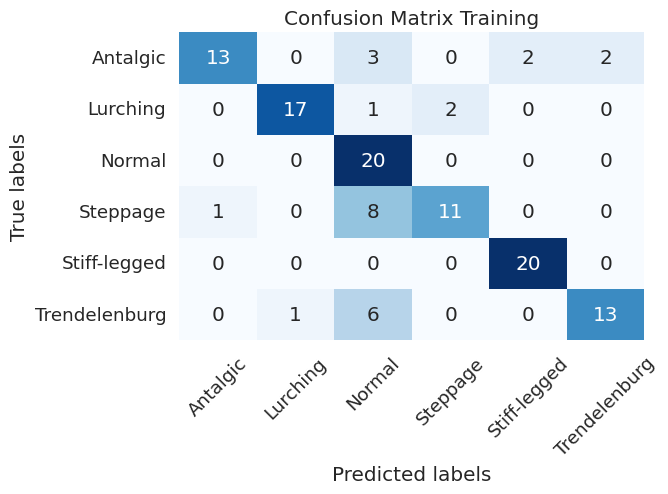

In [24]:
batch = 30
lr = 0.0001
train_steps = int(np.ceil(1200/batch))
val_steps = int(np.ceil(120/batch))

validation_loss = []
validation_accuracy = []
epochs = []
conf_matrix = np.zeros((6,6))

for i in np.arange(1, 12):

    sbj = i
    train_name_file = 'train_s_' + str(sbj)
    val_name_file = 'val_s_' + str(sbj)

    dataset_train = create_dataset(table = train,
                                   cache_file = train_name_file,
                                   shuffle = True,
                                   batch_size = batch,
                                   num_sbj=sbj,
                                   train = True)

    dataset_val = create_dataset(table = train,
                                 cache_file = val_name_file,
                                 shuffle = True,
                                 batch_size = batch,
                                 num_sbj=sbj,
                                 validation = True)

    final_model = complete_architecture((dim_input, ))

    final_model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    num_epochs = 400

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=20)

    results = final_model.fit(dataset_train,
                              epochs=num_epochs,
                              steps_per_epoch=train_steps,
                              validation_data=dataset_val,
                              validation_steps=val_steps,
                              callbacks=[early_stop_callback],
                              verbose = 0)

    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    validation_loss.append(np.mean(val_loss[-20:]))
    validation_accuracy.append(np.mean(val_accuracy[-20:]))
    epochs.append(len(train_accuracy))

    print()
    print('-----------------------------------------------------')
    print('Subject out: ', sbj)
    print('Stopped at epoch: ', len(train_accuracy))
    print('Validation loss achived is: ', np.round(np.mean(val_loss[-20:]), 6))
    print('Validation accuracy achived is: ', np.round(np.mean(val_accuracy[-20:]), 6))
    print('-----------------------------------------------------')

    t = np.arange(len(train_accuracy))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


    dataset_val_2 = create_dataset(table = train,
                                   cache_file = val_name_file,
                                   shuffle = False,
                                   batch_size = batch,
                                   num_sbj = sbj,
                                   validation = True,
                                   repeat = False)

    # compute predicted labels
    output_vector = final_model.predict(dataset_val_2)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    # extract truth labels
    num_samples_to_extract = 100
    dataset_sample = dataset_val_2.take(num_samples_to_extract)

    extracted_labels = []
    for _, label in dataset_sample:
        extracted_labels.extend(label.numpy().tolist())

    true_label = np.array(extracted_labels)

    # compute the error
    final_model.evaluate(dataset_val_2)

    # compute the confusion matrix
    cm = confusion_matrix(true_label, predicted_labels)
    conf_matrix = conf_matrix + cm

    print()

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
                yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Training')
    plt.show()

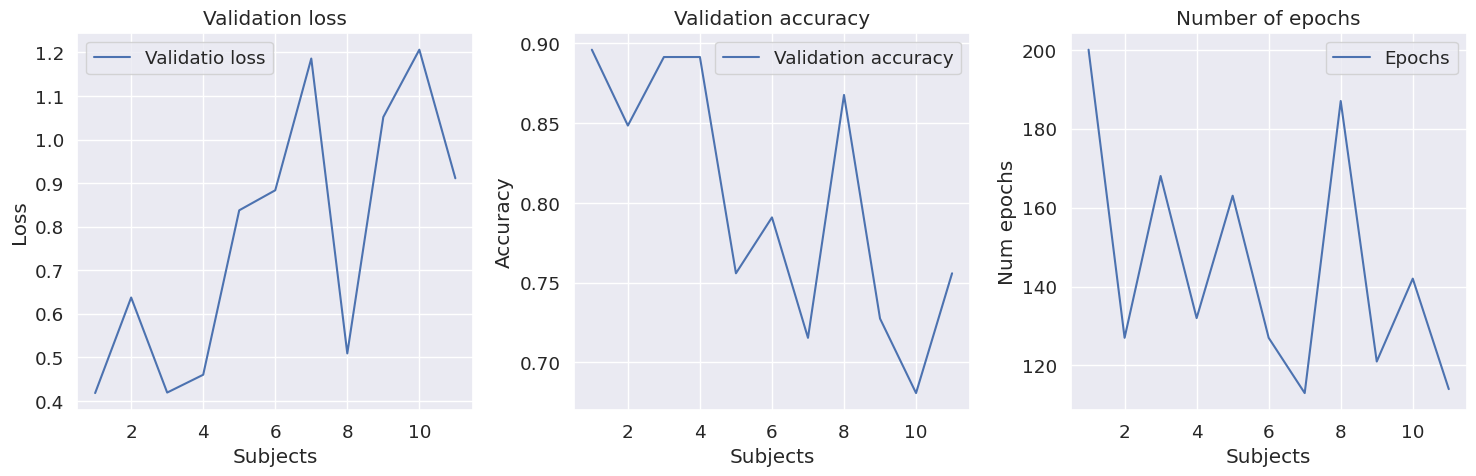


--------------------------------------------------
Batch size:  30
Learnig rate:  0.0001
Average validation loss:  0.77438
Average validation accuracy:  0.801856
--------------------------------------------------


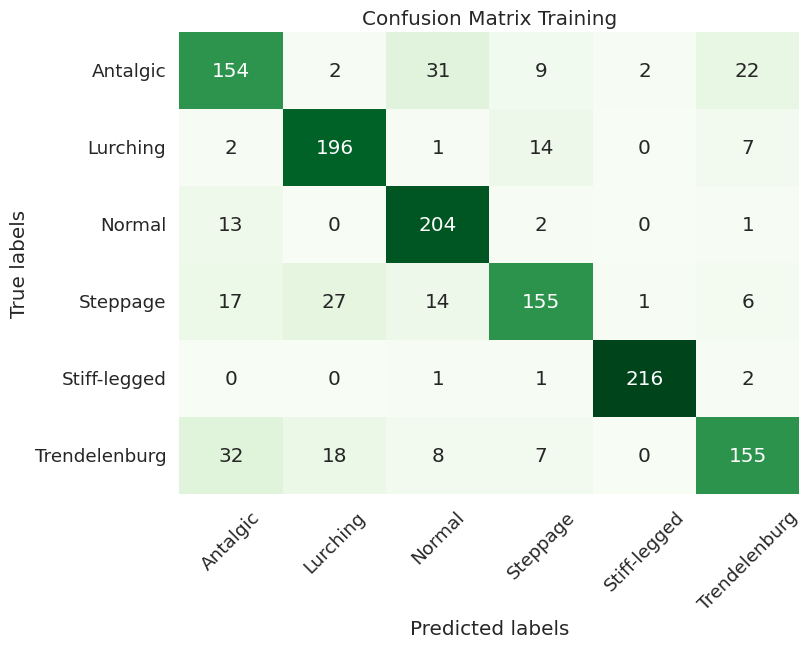

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

s = np.arange(1, 12)

ax1.plot(s, validation_loss, 'b', label='Validatio loss')
ax1.set_title('Validation loss')
ax1.set_xlabel('Subjects')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(s, validation_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Validation accuracy')
ax2.set_xlabel('Subjects')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(s, epochs, 'b', label='Epochs')
ax3.set_title('Number of epochs')
ax3.set_xlabel('Subjects')
ax3.set_ylabel('Num epochs')
ax3.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

print()
print('--------------------------------------------------')
print('Batch size: ', batch)
print('Learnig rate: ', lr)
print('Average validation loss: ', np.round(np.mean(validation_loss), 6))
print('Average validation accuracy: ', np.round(np.mean(validation_accuracy), 6))
print('--------------------------------------------------')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap="Greens", cbar=False,
            xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
            yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
plt.xticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Training')
plt.show()

In [26]:
def class_specific_metrics(cm, class_labels = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

df = class_specific_metrics(conf_matrix)
df

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.901515,0.700000,0.941818,0.706422
Lurching,0.946212,0.890909,0.957273,0.806584
Normal,0.946212,0.927273,0.950000,0.787645
Steppage,0.925758,0.704545,0.970000,0.824468
Stiff-legged,0.994697,0.981818,0.997273,0.986301
Trendelenburg,0.921970,0.704545,0.965455,0.803109
